# Linear Classifier - Softmax

In [498]:
# All necessary imports at the beginning
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata       
from sklearn.preprocessing import OneHotEncoder

## Load, explore and prepare dataset

The MNIST dataset is a classic Machine Learning dataset you can get it and more information about it from the website of [Yann Lecun](http://yann.lecun.com/exdb/mnist/). MNIST contains handwrittin digits and is split into a tranings set of 60000 examples and a test set of 10000 examples. You can use the module ```sklearn``` to load the MNIST dataset in a convenient way. 
easy load, mldata.org, orginal mnist, mnist link and description

In [499]:
mnist = fetch_mldata('MNIST original') #load MNIST
X, y = mnist["data"], mnist["target"] #separate images and labels

# shape of MNIST data
print('digits', X.shape)
print('labels',y.shape)

digits (70000, 784)
labels (70000,)


To get a visualization of MNIST we will plot a digit. Each line represents an image in flatten form (all pixel in a row). We have change the shape from a vector back to a matrix of the original shape to plot the image. In the case of MNIST this means a conversion of 784 pixel into 28x28 pixel. In addition we will check the label of that digit to verify it correspond to the image.

label: 0.0


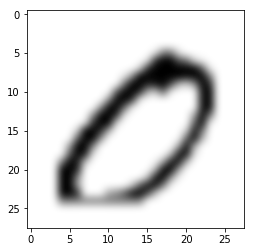

In [500]:
def plot_mnist_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap='binary', interpolation='bicubic')

#choose a random number, plot it and check label 
random_number = np.random.randint(1,60001)
print('label:',y[random_number]) 
plot_mnist_digit(X[random_number])


After a glimpse into MNIST let us explore it a bit further. Write a function ``` plot_mnist_digits(data, examples_each_row)``` that plots configurable number of examples for each class, like:
![MNIST Examples](images/MNIST_matrix.png)

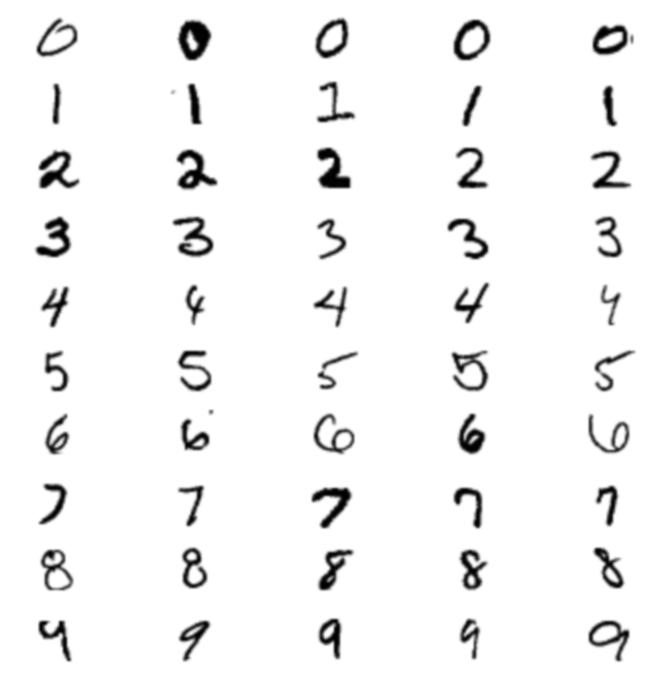

In [501]:
def plot_mnist_digits(data, examples_each_row):
    fig=plt.figure(figsize=(12, 12))                   #grandezza immagine totale 
    columns = examples_each_row
    rows = 10
    
    actual_row=0
    for i in range(1, columns*rows+1):
        image = get_img_from_number(actual_row).reshape(28, 28)
        
        if(i%columns == 0):
            actual_row=actual_row+1
            
        fig.add_subplot(rows, columns, i)  #dacapire
        plt.axis('off')
        plt.imshow(image, cmap='binary', interpolation='bicubic')

def get_img_from_number(num):
    while True:
        random_number = np.random.randint(1,60001)
        if (y[random_number]==num):
            return X[random_number]
        
    
plot_mnist_digits(X, examples_each_row=5)
plt.show() 

After exploring MNIST let us prepare the date for our linear classifier. First we need to separate traning and test data. Further we will shuffle the traning data to get a random distribution.  

In [502]:
# split data into training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# shuffle training data
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Define a linear classifier using Softmax

We will train a model to classify the MNIST dataset with the following equation:

$$ L = \frac{1}{M} \sum_{i=1}^{M} -log\; \left ( \frac{e^{h(x_j,\Theta)}}{\sum_{k=1}^{K}e^{h(x_k,\Theta)}} \right)_i + \frac{\lambda}{2} \sum_{}^{} \Theta^2, \: with \;\; h(X,\Theta) = X * \Theta $$

Using the universal equation for a loss function we can see the separate parts of that hugh equation.  

$$ L = \frac{1}{N} \sum_i L_i(h(x_i,\Theta),y_i) + \lambda R(\Theta)$$

We will implement each part on its own and put them together. That way it is much easier to understand whats going on. Let us start with the score function or hypothesis:

$$h(X,\Theta) = X * \Theta$$

It is possible to calculate all score values with one matrix multiplication ([dot product](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.dot.html)) so we can use the whole traning data $X$ instead of one digit $x_i$.

In [503]:
def class_scores(X,theta):              #everything without BIAS
    #X = np.array(list(map(lambda x: np.append(x,1), X)))
    return X.dot(theta)



After we can define the data loss funtion $L_i$. We assume the score values are unnormalized log probabilities and we use the softmax function to calculate probabilities.
$$ P(Y=j\mid X=x_i) = \frac{e^{s_j}}{\sum_{k=1}^{K}e^{s_k}} $$
$$ L_i = -log\;P(Y=j\mid X=x_i) $$

Hint: If the correct classes (labels) are in a [one hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) shape you can use a matrix multiplication to extract the correct class. 

In [504]:
# Support function to convert label vector into a one hot encoding matrix
def onehot_encode_label(label):
    onehot_encoder = OneHotEncoder(sparse=False)
    label = label.reshape(len(label), 1)
    onehot_encoded_label = onehot_encoder.fit_transform(label)
    return onehot_encoded_label

# Calculate class probability distribution for each digit from given class scores
def softmax(class_scores):
    class_scores_max = list(map(lambda x: np.max(x), class_scores))
    e_x = []
    for i in range (len(class_scores_max)):
        temp = np.exp(class_scores[i] - class_scores_max[i])
        e_x.append(temp/sum(temp))
    return e_x

# Compute data_loss L_i for the correct class
def data_loss(class_probabilities, onehot_encode_label):
    return -np.log(class_probabilities) * onehot_encode_label


Now we will calculate loss $L$ using the defined functions. 

$$ L = \frac{1}{M} \sum_i L_i(h(x_i,\Theta),y_i) + \lambda R(\Theta)$$

Besides the loss L we will have to calculate the gradient for our loss function $L$. To minimize our loss we will need the gradient. For more information about the gradient you can use additional sources, like that good [blog post](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/).

In [505]:
def loss(X, y, theta, lam):
    encoded_labels = onehot_encode_label(y)           # also needed for the gradient, therefore separated calculated
    probabilities = softmax(class_scores(X,theta))    # also needed for the gradient, therefore separated calculated
    loss_Li = data_loss(probabilities,encoded_labels) 
    
    m = X.shape[0]                                    # number of training data for normalization
    l2_regularization = (lam/2)*np.sum(theta*theta)   # regularization loss
  
    loss = 1/m * np.sum(loss_Li) + lam*l2_regularization
    
    temp =   probabilities - encoded_labels             #dacorreggere e capire
    gradient = 1/m * np.dot(X.T, temp) + lam*theta
    return loss,gradient

## Reduce the cost using gradient descent

In [506]:
def gradient_descent(traning_data, traning_label, theta, lam=0.5, iterations=100, learning_rate=1e-5):
    losses = []  #1e-5
    
    for i in range(iterations):
        l, gradient = loss(traning_data, traning_label, theta, lam)
        theta -= (gradient*learning_rate)
        losses.append(l)  
    return theta, losses

# Initialize learnable parameters theta 
theta = np.zeros([X_train.shape[1],len(np.unique(y_train))])
# Start optimization with traning data, theta and optional hyperparameters
opt_model, loss_history = gradient_descent(X_train,y_train,theta,iterations=50) #250

#theta = np.zeros([X_test.shape[1],len(np.unique(y_test))])
#opt_model, loss_history = gradient_descent(X_test,y_test,theta,iterations=30) #250




## Evaluate model
Let us look at the optimization results. Final loss tells us how far we could reduce costs during traning process. Further we can use the first loss value as a sanity check and validate our implementation of the loss function works as intended. Recall loss value after first iteration should be $ log\:c$ with $c$ being number of classes. To visulize the whole tranings process we can plot losss values from each iteration as a loss curve. 

last iteration loss: 0.43509186985747467
first iteration loss: 2.3025850929940446


Text(0.5,0,'iterations')

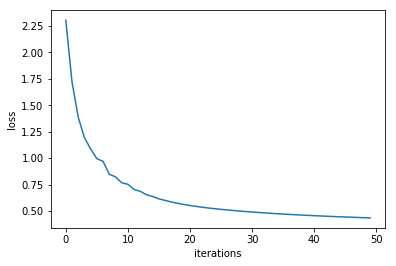

In [507]:
# check loss after last iteration
print('last iteration loss:',loss_history[-1])
# Sanity check: first loss should be ln(10)
print('first iteration loss:',loss_history[0])
# Plot a loss curve
plt.plot(loss_history)
plt.ylabel('loss')
plt.xlabel('iterations')


Evaluation above gave us some inside about the optimization process but did not quantified our final model. One possibility is to calculate model accuracy.

In [508]:
def modelAccuracy(X,y,theta):
    # calculate probabilities for each digit
    probabilities = softmax(np.dot(X,theta))
    # class with highest probability will be predicted
    prediction = np.argmax(probabilities,axis=1)
    # Sum all correct predictions and divied by number of data
    accuracy = (sum(prediction == y))/X.shape[0]
    return accuracy

print('Training accuracy: ', modelAccuracy(X_train,y_train,opt_model))
print('Test accuracy: ', modelAccuracy(X_test,y_test,opt_model))

Training accuracy:  0.88605
Test accuracy:  0.8929


But that quantification is limited. A more gerenell approach is to calculate a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and get different model measurements from it. A good overview for model measurements is provided by the wikipedia article of [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). We implement a confusion matrix for our model and calculate a [F1 score](https://en.wikipedia.org/wiki/F1_score) and ```print()``` it.

In [509]:
def confusionMatrix(X,y,theta):
    probabilities = softmax(class_scores(X,theta))
    y_pred = np.argmax(probabilities,axis=1)
    y = y.astype(np.int64)
    
    size = len(np.unique(y))
    conf_matrix = np.zeros((size,size), dtype=np.int)

    for i in range (len(y)):
        conf_matrix[y[i]][y_pred[i]] += 1
    return conf_matrix

import pandas as pd
def confusionMatrix2(X,y,theta):                     #Just for test   
    probabilities = softmax(class_scores(X,theta))
    y_pred = np.argmax(probabilities,axis=1)
    return pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

def f1Score(confMatrix):   #harmonic average of the precision and recall
    TP = np.diag(confMatrix)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = []
    
    for i in range(len(confMatrix)):
        temp = np.delete(confMatrix, i, 0)    # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    return 2 * (precision * recall) / (precision + recall)
    ############################################
    #             END OF YOUR CODE             #
    ############################################ 

print("My Confusion Matrix: ")
cm=confusionMatrix(X_test,y_test,opt_model)
print(cm)
print()
print("Panda Confusion Matrix: ")
print(confusionMatrix2(X_test,y_test,opt_model))
print()
print("My F1 Score: ")
print(f1Score(cm))
print()
print("Sklearn F1 Score: ")
probabilities = softmax(class_scores(X_test,opt_model))
y_pred = np.argmax(probabilities,axis=1)
from sklearn.metrics import f1_score
f2 = f1_score(y_test, y_pred, average=None)
print(f2)

My Confusion Matrix: 
[[ 957    0    2    3    0    2    8    1    7    0]
 [   0 1103    2    4    1    2    4    0   19    0]
 [  13    8  872   22   19    0   20   23   47    8]
 [   6    1   18  890    1   36    7   15   23   13]
 [   2    6    5    0  896    1   11    2    8   51]
 [  17    8    5   48   18  709   18    9   47   13]
 [  17    3    8    2   13   17  891    1    6    0]
 [   3   22   32    3   11    0    1  908    5   43]
 [  10   10   12   31    9   26   14   15  831   16]
 [  12    8    9   13   45   14    1   27    8  872]]

Panda Confusion Matrix: 
Predicted     0     1    2     3     4    5    6     7     8     9    All
Actual                                                                   
0.0         957     0    2     3     0    2    8     1     7     0    980
1.0           0  1103    2     4     1    2    4     0    19     0   1135
2.0          13     8  872    22    19    0   20    23    47     8   1032
3.0           6     1   18   890     1   36    7   

Interesting is to plot a part of $theta$, because you can visualize the learned templates for each class.

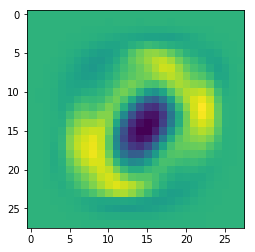

In [510]:
plt.imshow(np.reshape(opt_model[:,0],[28,28]))